In [50]:
import pandas as pd
import numpy as np
import warnings
import re
import string
import seaborn as sns
from matplotlib import style
import matplotlib.pyplot as plt

warnings.simplefilter('ignore')

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Nicy_Data_Science/olid-training-v1.0.tsv


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, SimpleRNN, Bidirectional, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix #to make classification report, confusion matrix
from sklearn.metrics import roc_curve, auc

from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.callbacks import EarlyStopping

import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 20] Not a directory: '/content/drive/MyDrive/Nicy_Data_Science/olid-training-v1.0.tsv'
/content


In [51]:
df_tweet = pd.read_csv('/content/drive/MyDrive/Nicy_Data_Science/olid-training-v1.0.tsv',sep='\t', usecols=['id', 'tweet', 'subtask_a'])
df_tweet.columns = ['ID', 'TWEET', 'LABEL']

# Replacing the categorical values for easy understanding. (Assigning 1 and 0 to offensive and not offensive tweets respectively)

df_tweet['LABEL'] = df_tweet['LABEL'].replace('OFF',1)
df_tweet['LABEL'] = df_tweet['LABEL'].replace('NOT',0)

#Selecting the label and tweet column for our further analysis
df_tweet=df_tweet[['TWEET','LABEL']]
df_tweet['LABEL'].unique() # Printing unique values of label variables

df_tweet.head()

,TWEET,LABEL
0,@USER She should ask a few native Americans wh...,1
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,1
2,Amazon is investigating Chinese employees who ...,0
3,"@USER Someone should'veTaken"" this piece of sh...",1
4,@USER @USER Obama wanted liberals &amp; illega...,0


In [52]:
#checking for null values in the tweet column
print(df_tweet['TWEET'].isnull().sum())

0


<Axes: xlabel='LABEL', ylabel='count'>

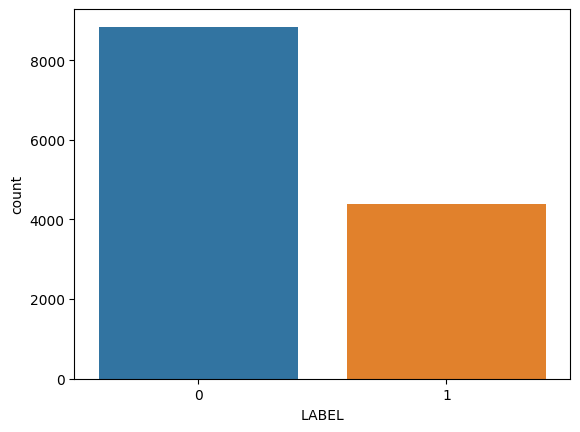

In [53]:
sns.countplot(data=df_tweet, x='LABEL')

In [54]:
tweets = df_tweet['TWEET']
labels = df_tweet['LABEL']

In [55]:
# Tokenize the tweets in the dataset and pad the text converted to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)
vocabulary_size = len(tokenizer.word_index) + 1

sequences = tokenizer.texts_to_sequences(tweets)# Convert tokenised text to sequences
max_length_seq = max(len(seq) for seq in sequences) # Pad sequences to the maximum length of sequence
padded_seq = pad_sequences(sequences, maxlen=max_length_seq, padding='post')

In [56]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_seq, labels, test_size=0.2, random_state=42)

# **Deep Learning Models**

1. Simple RNN

In [57]:
# Build the RNN model
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=50, input_length=max_length_seq))
model.add(SimpleRNN(units=50, activation='tanh'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [59]:
# Train the RNN model with training dataset
model.fit(X_train, y_train, epochs=20, batch_size=100, validation_split=0.2)

Epoch 1/20
85/85 [==============================] - 5s 48ms/step - loss: 0.6375 - accuracy: 0.6667 - val_loss: 0.6282 - val_accuracy: 0.6810
Epoch 2/20
85/85 [==============================] - 6s 66ms/step - loss: 0.6379 - accuracy: 0.6654 - val_loss: 0.6294 - val_accuracy: 0.6810
Epoch 3/20
85/85 [==============================] - 6s 66ms/step - loss: 0.6349 - accuracy: 0.6686 - val_loss: 0.6261 - val_accuracy: 0.6810
Epoch 4/20
85/85 [==============================] - 4s 48ms/step - loss: 0.6346 - accuracy: 0.6686 - val_loss: 0.6262 - val_accuracy: 0.6810
Epoch 5/20
85/85 [==============================] - 4s 48ms/step - loss: 0.6361 - accuracy: 0.6685 - val_loss: 0.6289 - val_accuracy: 0.6810
Epoch 6/20
85/85 [==============================] - 7s 83ms/step - loss: 0.6364 - accuracy: 0.6686 - val_loss: 0.6264 - val_accuracy: 0.6810
Epoch 7/20
85/85 [==============================] - 4s 49ms/step - loss: 0.6356 - accuracy: 0.6686 - val_loss: 0.6262 - val_accuracy: 0.6810
Epoch 8/20
85

In [60]:
# Evaluate the RNN model on the test set
y_pred = model.predict(X_test)
rnn_round_predict = [round(pred[0]) for pred in y_pred]

# Printing the classification report
print("\nClassification Report for RNN model:")
print(classification_report(y_test, rnn_round_predict))

83/83 [==============================] - 1s 11ms/step

Classification Report for RNN model:
              precision    recall  f1-score   support

           0       0.67      0.76      0.71      1733
           1       0.39      0.30      0.34       915

    accuracy                           0.60      2648
   macro avg       0.53      0.53      0.52      2648
weighted avg       0.57      0.60      0.58      2648



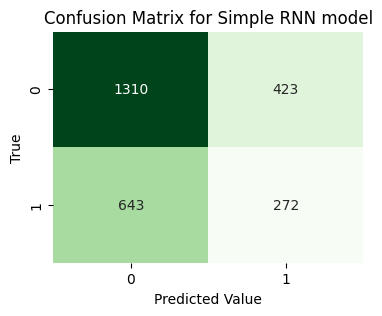

In [61]:
confusion_matrices = confusion_matrix(y_test,rnn_round_predict)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrices, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("Confusion Matrix for Simple RNN model")
plt.xlabel("Predicted Value")
plt.ylabel("True")
plt.show()

2. BiLSTM model

In [62]:
# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=32, input_length=max_length_seq))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Bidirectional(LSTM(units=64)))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [63]:
# Train the model with the training set of data
model.fit(X_train, y_train, epochs=20, batch_size=100, validation_split=0.2)

Epoch 1/20
85/85 [==============================] - 73s 760ms/step - loss: 0.6267 - accuracy: 0.6685 - val_loss: 0.5881 - val_accuracy: 0.6918
Epoch 2/20
85/85 [==============================] - 60s 714ms/step - loss: 0.4564 - accuracy: 0.7968 - val_loss: 0.5487 - val_accuracy: 0.7461
Epoch 3/20
85/85 [==============================] - 67s 789ms/step - loss: 0.2676 - accuracy: 0.8972 - val_loss: 0.6348 - val_accuracy: 0.7367
Epoch 4/20
85/85 [==============================] - 60s 714ms/step - loss: 0.1756 - accuracy: 0.9397 - val_loss: 0.7766 - val_accuracy: 0.7282
Epoch 5/20
85/85 [==============================] - 62s 729ms/step - loss: 0.1188 - accuracy: 0.9628 - val_loss: 0.8939 - val_accuracy: 0.6947
Epoch 6/20
85/85 [==============================] - 61s 720ms/step - loss: 0.0991 - accuracy: 0.9700 - val_loss: 1.0136 - val_accuracy: 0.7202
Epoch 7/20
85/85 [==============================] - 62s 729ms/step - loss: 0.0857 - accuracy: 0.9737 - val_loss: 0.9719 - val_accuracy: 0.7154

In [64]:
# Evaluate the LSTM model on the test set
y_pred = model.predict(X_test)
lstm_round_predict = [round(pred[0]) for pred in y_pred]

# Printing the classification report
print("\nClassification Report for BiLSTM model:")
print(classification_report(y_test, lstm_round_predict))

83/83 [==============================] - 6s 57ms/step

Classification Report for BiLSTM model:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      1733
           1       0.55      0.58      0.57       915

    accuracy                           0.69      2648
   macro avg       0.66      0.67      0.66      2648
weighted avg       0.70      0.69      0.69      2648



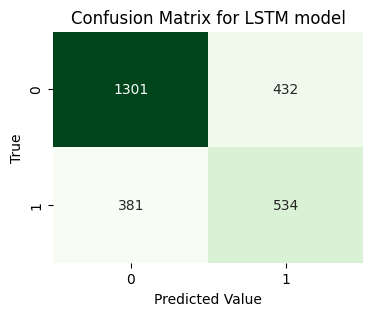

In [65]:
confusion_matrices = confusion_matrix(y_test,lstm_round_predict)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrices, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("Confusion Matrix for LSTM model")
plt.xlabel("Predicted Value")
plt.ylabel("True")
plt.show()

3. CNN model

In [66]:
# Define the CNN model
embedding_dim = 50
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=50, input_length=max_length_seq))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=1, activation='sigmoid'))

In [67]:
# The model is compiled
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Show the model summary
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 105, 50)           1062200   
                                                                 
 conv1d_2 (Conv1D)           (None, 103, 64)           9664      
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1071929 (4.09 MB)
Trainable params: 1071929 (4.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [68]:
# Training the CNN model
model.fit(X_train, y_train, epochs=20, batch_size=50, validation_split=0.2)

Epoch 1/20
170/170 [==============================] - 8s 41ms/step - loss: 0.6272 - accuracy: 0.6706 - val_loss: 0.5861 - val_accuracy: 0.7164
Epoch 2/20
170/170 [==============================] - 4s 25ms/step - loss: 0.4888 - accuracy: 0.7661 - val_loss: 0.4848 - val_accuracy: 0.7725
Epoch 3/20
170/170 [==============================] - 4s 24ms/step - loss: 0.3327 - accuracy: 0.8550 - val_loss: 0.5029 - val_accuracy: 0.7735
Epoch 4/20
170/170 [==============================] - 6s 34ms/step - loss: 0.1972 - accuracy: 0.9288 - val_loss: 0.5657 - val_accuracy: 0.7645
Epoch 5/20
170/170 [==============================] - 5s 30ms/step - loss: 0.1063 - accuracy: 0.9679 - val_loss: 0.6684 - val_accuracy: 0.7541
Epoch 6/20
170/170 [==============================] - 4s 24ms/step - loss: 0.0569 - accuracy: 0.9874 - val_loss: 0.7806 - val_accuracy: 0.7570
Epoch 7/20
170/170 [==============================] - 4s 26ms/step - loss: 0.0348 - accuracy: 0.9924 - val_loss: 0.8546 - val_accuracy: 0.7466

In [69]:
# Evaluate the CNN model on the test set
predictions = model.predict(X_test)
cnn_round_predict = [round(pred[0]) for pred in predictions]

# Printing the classification report for CNN model
print("\nClassification Report for CNN model")
print(classification_report(y_test, cnn_round_predict))

83/83 [==============================] - 0s 3ms/step

Classification Report for CNN model
              precision    recall  f1-score   support

           0       0.77      0.82      0.79      1733
           1       0.61      0.53      0.57       915

    accuracy                           0.72      2648
   macro avg       0.69      0.68      0.68      2648
weighted avg       0.71      0.72      0.72      2648



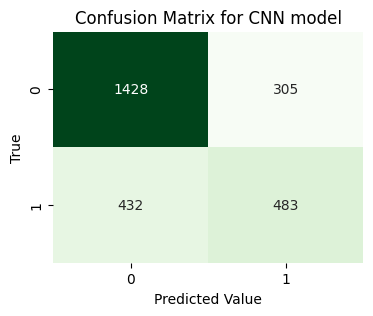

In [70]:
confusion_matrices = confusion_matrix(y_test,cnn_round_predict)

# Plotting the confusion matrix for CNN model as a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrices, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("Confusion Matrix for CNN model")
plt.xlabel("Predicted Value")
plt.ylabel("True")
plt.show()